# Cellular automata for controlled fires

In [ ]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from matplotlib import cm
import random

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

np.random.seed(0) 

##Utils

In [ ]:
def visualize_state(matrix):
  ax = plt.axes()
  ax.set_axis_off()

  custom_map = [[1,1,1,0], #white
                [1,0.6,0,1], #orange
                [1,0,0,1], #red
                [0.6,0.6,0.6,1], #gray
                [0,0,0,1]] #black 
  greens_ = cm.get_cmap('Greens', 8)
  greens =[greens_(0.2), 
          greens_(0.4),
          greens_(0.6), 
          greens_(0.8), 
          greens_(0.99)] 

  im1 = ax.imshow(matrix[1,:,:], interpolation='none',cmap=colors.ListedColormap(greens))
  im2 = ax.imshow(matrix[0,:,:], interpolation='none',cmap=colors.ListedColormap(custom_map)) #RdPu
  plt.show()


In [ ]:
def distance(radio, size, coor):
    """
    input: the radio, the size of the latice, and the cell to calculate the neighboorhood
    output: the coordinates of the neighbouring cells

    This function calculates the cells in the Moore neighborhood of radius r of a given cell. 
    Is important to notice that this does not include the cel in for example the first an second neighborhood 
    when calculation the third one. 
    """
    assert 1 <= radio <= 3
    r = radio
    size = size
    coordinate = coor

    neigh_i = []
    neigh_j = []

    for i in range(-radio, radio + 1):
      for j in range(-radio, radio + 1):
        if (i+coordinate[0])>=0 and (i+coordinate[0])< size and (j+coordinate[1])>=0 and (j+coordinate[1])< size and (i != 0 or j != 0):
          neigh_i.append(i+coordinate[0])
          neigh_j.append(j+coordinate[1])
    return [neigh_i, neigh_j]


## Parameters

### Cell states:
0 - Unburned vegetation
1 - Ignited vegetation
2 - Burning vegetation
3 - Ash
4 - Bare Soil

### Vegetation density
0 - 4 not dense to very dense

### Humidity
3 rates
* dry 
* wet
* very wet

### Duration of burning
T depends on the vegetation density and the humidity, as the humidity increases the burning rate increases too.

## Matrix initialization

In [ ]:
def matrix_build(matrix, size, veg, hum):
# Initial construction
    matrix[0,:,:] = np.zeros(shape = (size, size))

    #relative humidity using normal distribution centered in 53 
    #mu_hum, sigma = 53, 17
    #hum = np.random.normal(mu_hum, sigma)

    #veg = np.random.choice(['low','mid','high'], p=[0.25, 0.42, 0.33])

    if hum<40: #if low RH then low humidity of the soil
        for i in range(size):
            for j in range(size):
                if veg =='low':
                    matrix[2,i,j] = 0 #humidity
                    matrix[1,i,j] = np.random.choice([random.choice([0,1]),2,3], p=[0.5, 0.2, 0.3])  #vegetation
                elif veg == 'mid':
                    matrix[2,i,j] = random.choice([0,1]) #humidity
                    matrix[1,i,j] = np.random.choice([random.choice([2,3]),1,4], p=[0.7, 0.15, 0.15]) 
                else:
                    matrix[2,i,j] = 1 #humidity
                    matrix[1,i,j] = np.random.choice([4, 3], p=[0.7, 0.3]) 

    elif hum>=40 and hum<60:
        for i in range(size):
            for j in range(size):
                if veg =='low':
                    matrix[2,i,j] = random.choice([0,1]) #humidity
                    matrix[1,i,j] = np.random.choice([random.choice([0,1]),2], p=[0.75, 0.25])  #vegetation
                elif veg == 'mid':
                    matrix[2,i,j] = random.choice([1,2]) #humidity
                    matrix[1,i,j] = np.random.choice([random.choice([2,3]),1,4], p=[0.5, 0.15, 0.35]) 
                else:
                    matrix[2,i,j] = random.choice([1,2]) #humidity
                    matrix[1,i,j] = np.random.choice([4, 3], p=[0.7, 0.3]) 
 
    elif hum>=60:
        for i in range(size):
            for j in range(size):
                if veg =='low':
                    matrix[2,i,j] = 1 #humidity
                    matrix[1,i,j] = np.random.choice([random.choice([0,1]),2], p=[0.75, 0.25])  #vegetation
                elif veg == 'mid':
                    matrix[2,i,j] = random.choice([1,2])#humidity
                    matrix[1,i,j] = np.random.choice([random.choice([2,3]),1,4], p=[0.7, 0.15, 0.15]) 
                else:
                    matrix[2,i,j] = random.choice([1,2]) #humidity
                    matrix[1,i,j] = np.random.choice([4, 3], p=[0.7, 0.3])
    return matrix

## Step function

In [ ]:
# propagation probs depending on the neighbours on fire
fire_probs = [0, 0.5, 0.65, 0.75, 0.8, 0.9, 0.95, 0.98, 1]

def transition_times_2_3(density, alpha):
  '''
  Determines the time steps to take froms state 2 to 3
  '''
  return (alpha+1)*(density+1)


def step(matrix, Tfire):
  '''
  update the cell
  '''
  size = matrix.shape[1]  #was missing the var size
  old_states = np.copy(matrix[0,:,:])
  old_humidity = np.copy(matrix[2,:,:])

  # from state 0 to 1:
  for i in range(size):
      for j in range(size):
        neighs = distance(1, size, [i,j])
        neighs_fires = old_states[neighs[0], neighs[1]]
        if (matrix[1,i,j] != 0) and (np.random.rand() < fire_probs[int(np.count_nonzero(neighs_fires == 1))]) and (old_humidity[i,j] < 2) and (old_states[i,j] == 0): #(any(neighs_fires == 1))
          matrix[0,i,j] = 1
          #print('0 to 1')
          Tfire[i,j] = transition_times_2_3(matrix[1,i,j], old_humidity[i,j]) #determine Tfire of the cell: change?

        #from state 1 to 2:
        elif old_states[i,j] == 1:
          matrix[0,i,j] = 2

        #from state 2 to 3: if Tfire of a cell 2 is 0, go to state 3
        elif old_states[i,j] == 2 and Tfire[i,j] == 0:
          matrix[0,i,j] = 3

        #from state 3 to 4:
        elif old_states[i,j] == 3:
          matrix[0,i,j] = 4
        
        #random jump: if vegetation is very dense
        if np.random.rand() < 0.1 and matrix[1,i,j] == 4 and old_states[i,j] == 2:
          rand_coor = np.random.randint(-10, 10, size=2) + [i,j]
          if all(rand_coor > 0) and all(rand_coor < size):
            if matrix[1, rand_coor[0], rand_coor[1]] > 0 and old_states[ rand_coor[0], rand_coor[1]] == 0: 
              matrix[0,rand_coor[0], rand_coor[1]] = 1
        
        # update humidity: if it is 2 and a neighbour is on fire, set to 1
        if (any(old_states[neighs[0], neighs[1]] == 1)) and old_humidity[i,j] == 2: #add also neighbour with fire 2?
          matrix[2,i,j] = 1


  #update params
  Tfire = np.clip(Tfire - 1, 0, None) # update Tfire
  
  return matrix, Tfire

## Build and call CA

Running epoch 1

0/250:


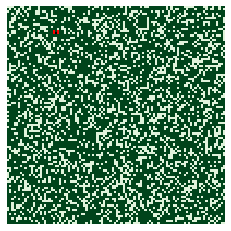


20/250:


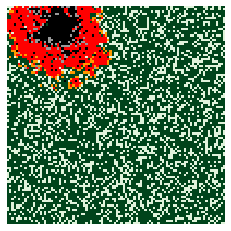


40/250:


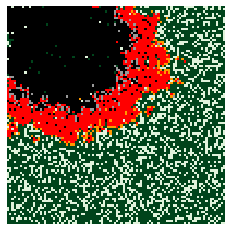


60/250:


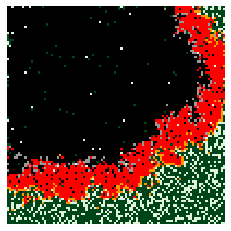


80/250:


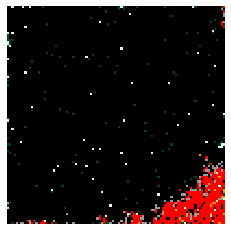


100/250:


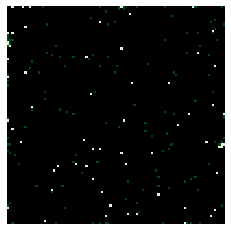


120/250:


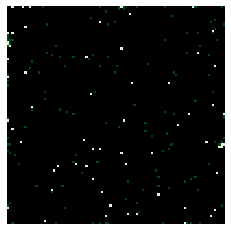


140/250:


KeyboardInterrupt: ignored

In [ ]:
def count_veg(mat): # used to count the cells with vegetation and burned cells
  count = 0
  for row in mat:
    count += np.count_nonzero(row > 0)
  return count

def cell_automata(size, steps, epochs, veg, hum, show_im = 0):
  #init parameters
  '''
  Matrix contains:
  0) cell state: 5 states (int)
  1) vegetation density: 5 states, from nothing to very dense (int) (TEMP)
  2) humidity: 3 rates (int)
  '''
  num_params = 3
  matrix = np.zeros(shape = (num_params, size, size))
    
  x = np.zeros(shape = (epochs, steps, size, size)) # save results
  num_veg = []

  for epoch in range(epochs):
    print(f'Running epoch {epoch+1}')
    #reset matrix and Tfire
    Tfire = np.zeros(shape = (size, size))
    matrix = matrix_build(matrix, size, veg, hum)
    num_veg.append(count_veg(matrix[1,:,:]))

    #init random fire
    ind = np.where(matrix[1,:,:] != 0)
    ran = np.random.randint(len(ind[0]))
    matrix[0,ind[0][ran],ind[1][ran]] = 1

    #step
    for i in range(steps):
      matrix, Tfire = step(matrix,Tfire)
      x[epoch,i,:,:] = np.copy(matrix[0,:,:])
      if show_im != 0:
        if i%show_im == 0:
          print(f'\n{i}/{steps}:')
          visualize_state(matrix)

  return x, num_veg

epochs = 20
size = 100#350 #cell size
steps = 250#600
veg = 'high'
hum = 50 #20, 50, 70

x, num_veg = cell_automata(size, steps, epochs, veg, hum, show_im = 20)
np.save(f'array_veg_{veg}_hum_{hum}.npy', x)
#np.save(f'numveg_veg_{veg}_hum_{hum}.npy', num_veg)

## Analyse results

In [ ]:
# percentage of vegetation burned
burned_cells = [] # ignited, burning, ash or burned: list of lists

# each element is for each epoch, and each inner list is the percentage every 10 steps of that epoch
for epoch in range(epochs):
  temp = []
  for step in range(steps):
    if step%10 == 0:
      temp.append(count_veg(x[epoch,step,:,:])/num_veg[epoch])
  burned_cells.append(temp)

#print(np.array(burned_cells), num_veg)
np.save(f'percentages_veg_{veg}_hum_{hum}.npy', burned_cells)

# Plots

0.9174933838342044
0.9827349999999999
0.9386299999999999


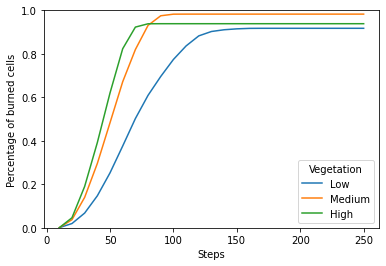

In [ ]:
perc0=np.load('percentages_veg_low_hum_20.npy')
perc1=np.load('percentages_veg_mid_hum_20.npy')
perc2=np.load('percentages_veg_high_hum_20.npy')
perc=[perc0,perc1,perc2]
labels=['Low','Medium','High']

for j in range(3):
  means=[0]*25
  for i in range(25):
    means[i]=np.mean(perc[j][:,i].mean())
  print(means[24])
  time=np.arange(10, 250+1, 10)
  plt.plot(time,means,label=labels[j])
ax = plt.gca()
ax.set_ylim([0, 1])
plt.xlabel('Steps')
plt.ylabel('Percentage of burned cells')
plt.legend(title='Vegetation')
plt.show()

0.19731738961694922
0.831205
0.835135


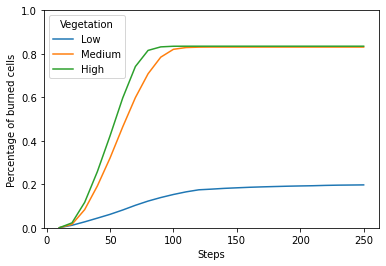

In [ ]:
perc0=np.load('percentages_veg_low_hum_50.npy')
perc1=np.load('percentages_veg_mid_hum_50.npy')
perc2=np.load('percentages_veg_high_hum_50.npy')
perc=[perc0,perc1,perc2]
labels=['Low','Medium','High']

for j in range(3):
  means=[0]*25
  for i in range(25):
    means[i]=np.mean(perc[j][:,i].mean())
  print(means[24])
  time=np.arange(10, 250+1, 10)
  plt.plot(time,means,label=labels[j])
ax = plt.gca()
ax.set_ylim([0, 1])
plt.xlabel('Steps')
plt.ylabel('Percentage of burned cells')
plt.legend(title='Vegetation')
plt.show()

0.2090749438415998
0.7798849999999999
0.9824449999999999


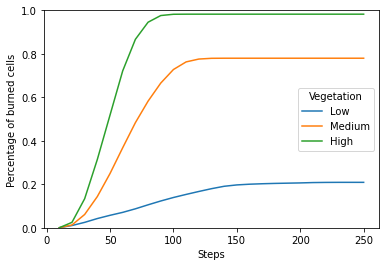

In [ ]:
perc0=np.load('percentages_veg_low_hum_70.npy')
perc1=np.load('percentages_veg_mid_hum_70.npy')
perc2=np.load('percentages_veg_high_hum_70.npy')
perc=[perc0,perc1,perc2]
labels=['Low','Medium','High']

for j in range(3):
  means=[0]*25
  for i in range(25):
    means[i]=np.mean(perc[j][:,i].mean())
  print(means[24])
  time=np.arange(10, 250+1, 10)
  plt.plot(time,means,label=labels[j])
ax = plt.gca()
ax.set_ylim([0, 1])
plt.xlabel('Steps')
plt.ylabel('Percentage of burned cells')
plt.legend(title='Vegetation')
plt.show()

## Temporal tests

Code from https://github.com/IlievskiV/Amusive-Blogging-N-Coding/blob/master/Cellular%20Automata/cellular_automata.ipynb \\
Explanation https://towardsdatascience.com/simple-but-stunning-animated-cellular-automata-in-python-c912e0c156a9